## Regularization

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

In [193]:
# Load data
yelp_df = pd.read_csv('/Users/AuerPower/Metis/git/predict_gentrification_with_yelp/data/yelp_predictors.csv')
zillow_df = pd.read_csv('/Users/AuerPower/Metis/git/predict_gentrification_with_yelp/data/house_price_changes.csv')

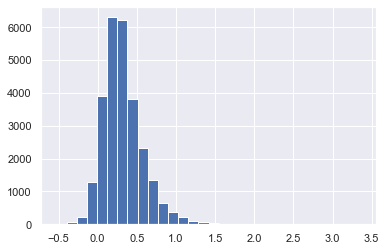

In [194]:
# Plot distribution of target variable
zillow_df['change_2010_2019'].hist(bins=30)

In [195]:
# get rid of useless rows
zillow_df_change = zillow_df.drop(columns=['Unnamed: 0', 'RegionID', 'City',
                                    'State', 'Metro', 'avg_growth_rate_2010_2019'])
# change zip code to str and merge
zillow_df_change['RegionName'] = zillow_df_change['RegionName'].astype('str')
df = zillow_df_change.merge(yelp_df, how='inner', left_on = 'RegionName', right_on='postal_code')
df = df.drop(columns=['RegionName', 'postal_code', 'Unnamed: 0', 'median_2015_2019'])
df = df.dropna()

In [196]:
# Set up for modeling

#Separate our features from our target

X, y = df.drop('change_2010_2019', axis=1), df['change_2010_2019']

In [197]:
# Set up for modeling V2 after I did regularization and found features that I should remove
X, y = df.drop('change_2010_2019', axis=1), df['change_2010_2019']

In [198]:
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [199]:
selected_columns = X.columns
selected_columns

Index(['open_business', 'reviews_per_business', 'avg_stars', 'categories',
       'dis_income', 'total_photo'],
      dtype='object')

In [200]:
lasso_model = Lasso(alpha = .019) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X_train.loc[:,selected_columns], y_train)

Lasso(alpha=0.019, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [201]:
list(zip(selected_columns, lasso_model.coef_))

[('open_business', -0.0),
 ('reviews_per_business', 0.0022259674297604214),
 ('avg_stars', 0.0),
 ('categories', 0.0),
 ('dis_income', 0.0031488874487467307),
 ('total_photo', -8.005664385567485e-05)]

In [202]:
X_train_collinear = X_train.loc[:,selected_columns]

In [203]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

model = sm.OLS(y_train, sm.add_constant(X_train_collinear))
results = model.fit()

results.summary()

/Users/AuerPower/opt/miniconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       change_2010_2019   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     33.16
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           4.10e-32
Time:                        17:52:56   Log-Likelihood:                -99.104
No. Observations:                 386   AIC:                             212.2
Df Residuals:                     379   BIC:                             239.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2509      0.132      1.899      0.058      -0.009       0.511
open_business           -0.0500      0.098     -0.510      0.610      -0.242       0.143
reviews_per_business     0.0022      0.000      6.913      0.000       0.002       0.003
avg_stars                0.0260      0.027      0.973      0.331      -0.027       0.079
categories             214.3189     22.575      9.494      0.000     169.931     258.707
dis_income              -0.0114      0.002     -7.083      0.000      -0.015      -0.008
total_photo           1.885e-05    2.4e-05      0.786      0.433   -2.83e-05     6.6e-05
==============================================================================
Omnibus:                       65.583   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.305
Skew:                           1.081   Prob(JB):                     4.50e-22
Kurtosis:                       4.199   Cond. No.                     1.56e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [204]:
# Ridge
lr_model_ridge = Ridge(alpha = .019)
lr_model_ridge.fit(X_train_collinear, y_train)

list(zip(X_train_collinear.columns, lr_model_ridge.coef_))

[('open_business', -0.04517323845393393),
 ('reviews_per_business', 0.0021889279470766305),
 ('avg_stars', 0.013648444209655742),
 ('categories', 2.1831859866839656),
 ('dis_income', 0.0029836460886644755),
 ('total_photo', -7.879986432301198e-05)]

In [205]:
# Lasso
lr_model_lasso = Lasso(alpha = .019)
lr_model_lasso.fit(X_train_collinear, y_train)

list(zip(X_train_collinear.columns, lr_model_lasso.coef_))

[('open_business', -0.0),
 ('reviews_per_business', 0.0022259674297604214),
 ('avg_stars', 0.0),
 ('categories', 0.0),
 ('dis_income', 0.0031488874487467307),
 ('total_photo', -8.005664385567485e-05)]

In [206]:
test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])

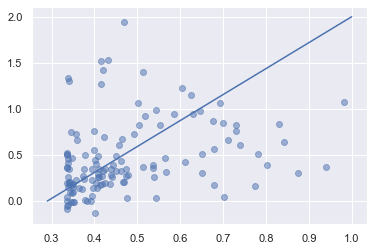

In [207]:
plt.scatter(test_set_pred, y_test, alpha=.5)
plt.plot(np.linspace(0.29,1,10), np.linspace(0,2,10));

In [208]:
#r-squared
r2_score(y_test, test_set_pred)

0.08261020118709728

In [209]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

0.2815922012363556

# Standard-scaling Features

In [210]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [211]:
## This step fits the Standard Scaler to the training data
## Essentially it finds the mean and standard deviation of each variable in the training set

std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [212]:
## This step applies the scaler to the train set and to the test set
## It subtracts the mean it learned in the previous step and then divides by the standard deviation

X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

(array([278.,  67.,  26.,   4.,   4.,   4.,   1.,   1.,   0.,   1.]),
 array([-0.6555585 ,  0.18970958,  1.03497766,  1.88024574,  2.72551383,
         3.57078191,  4.41604999,  5.26131807,  6.10658616,  6.95185424,
         7.79712232]),
 <a list of 10 Patch objects>)

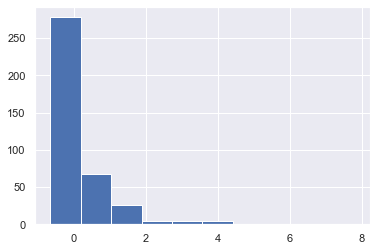

In [214]:
## Here we can plot histograms of the transformed variables
## Note that they seem to have means of 0 and stddevs of 1
## (though they are not necessarily normally distributed)

plt.hist(X_tr[:,3])

Now that we have appropriately scaled our variables, we can apply the LASSO again.

In [215]:
## Fit a LASSO model on the standardized data
lasso_model = Lasso(alpha = .019)
lasso_model.fit(X_tr,y_train)
list(zip(X_train.columns, lasso_model.coef_))

[('open_business', -0.0),
 ('reviews_per_business', 0.0958507372680279),
 ('avg_stars', 0.0),
 ('categories', 0.13674959822890143),
 ('dis_income', -0.0),
 ('total_photo', -0.040006525287248)]

In [216]:
from sklearn.metrics import r2_score

In [218]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

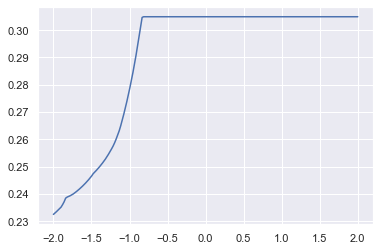

In [219]:
plt.plot(np.log10(alphalist), err_vec_val)

In [220]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.01

# Automated Regularization Strength Tuning via Cross-validation

In [221]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [222]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [223]:
# Best alpha value it found 
lasso_model.alpha_

0.018251834943190434

In [224]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

[('open_business', -0.0),
 ('reviews_per_business', 0.09666922650933772),
 ('avg_stars', 0.0),
 ('categories', 0.13865857089809386),
 ('dis_income', -0.0),
 ('total_photo', -0.04209425725569545)]

In [225]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [226]:
r2_score(y_test, test_set_pred)

0.16782558533743075

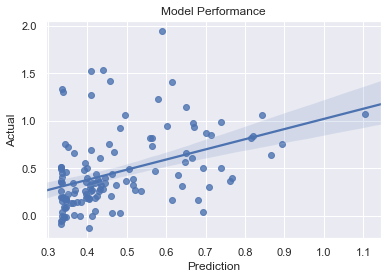

In [227]:
#plt.scatter(test_set_pred, y_test, alpha=.5)
ax = sns.regplot(x=test_set_pred, y=y_test)
ax.set(title="Model Performance" ,xlabel='Prediction', ylabel='Actual')
plt.savefig("outputs/model_performance_transparent.svg", transparent= True)

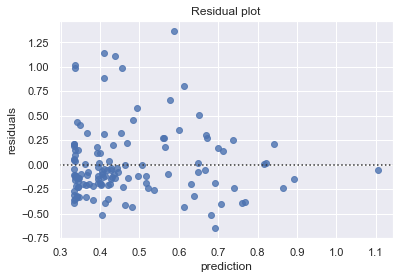

In [228]:
# create residual plot
res = y_test - test_set_pred
ax = sns.residplot(test_set_pred, res)
ax.set(title="Residual plot" ,xlabel="prediction", ylabel="residuals")
#ax.savefig("residual_plot.svg")
plt.savefig("outputs/residual_plot.svg")